# Topic Models for Buffer Strip Research

In this script we run some topic models on the dataset and view the results in a couple of ways

Parts of this script are based on the sklearn topic model example found at https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [1]:
import pandas as pd
import numpy as np

## First we load the dataset and do some cleaning

In [2]:
df = pd.read_csv('data/20211019_rwbs_lens-export.csv')
print(df.shape)
print(df.columns)

missings = df[pd.isna(df['Abstract'])].index
print(f"Removing {missings.shape[0]} with missing Abstract")
df = df[~df.index.isin(missings)].reset_index(drop=True)

print(df.shape)

# clean the abstract text to remove copyright and other procedural parts
df['Abstract'] = df['Abstract'].str.replace("(\(C).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("(\[C).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("(Elsevier Science).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("^Abstract:","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("(\[ABSTRACT).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("Copyright.*","",regex=True)



df.head()

(987, 29)
Index(['Lens ID', 'Title', 'Date Published', 'Publication Year',
       'Publication Type', 'Source Title', 'ISSNs', 'Publisher',
       'Source Country', 'Author/s', 'Abstract', 'Volume', 'Issue Number',
       'Start Page', 'End Page', 'Fields of Study', 'Keywords', 'MeSH Terms',
       'Chemicals', 'Funding', 'Source URLs', 'External URL', 'PMID', 'DOI',
       'Microsoft Academic ID', 'PMCID', 'Citing Patents Count', 'References',
       'Citing Works Count'],
      dtype='object')
Removing 165 with missing Abstract
(822, 29)


,Lens ID,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,Author/s,...,Funding,Source URLs,External URL,PMID,DOI,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count
0,000-028-962-557-075,Importance of hedgerows as habitat corridors f...,NaN,2009.0,journal article,Biological Conservation,00063207,Elsevier BV,Netherlands,Stephan Wehling; Martin Diekmann,...,NaN,https://pubag.nal.usda.gov/catalog/766751 http...,http://dx.doi.org/10.1016/j.biocon.2009.05.023,NaN,10.1016/j.biocon.2009.05.023,2.043999e+09,NaN,0,001-555-373-960-238; 002-874-438-870-319; 007-...,66
1,000-065-021-648-613,Avian use of Sheyenne Lake and associated habi...,1982-03-01,1982.0,journal article,Resource Publication,NaN,NaN,NaN,Craig A. Faanes,...,NaN,http://www.npwrc.usgs.gov/resource/birds/sheyl...,http://www.npwrc.usgs.gov/resource/birds/sheyl...,NaN,NaN,1.530721e+09,NaN,0,002-817-587-407-853; 016-356-453-015-079; 019-...,12
2,000-140-507-815-44X,Landscape composition models for breeding bird...,NaN,1997.0,journal article,Ecography,09067590; 16000587,Wiley,United Kingdom,R. J. Fuller; R. J. Trevelyan; R. W. Hudson,...,NaN,https://www.jstor.org/stable/3682841 https://o...,http://dx.doi.org/10.1111/j.1600-0587.1997.tb0...,NaN,10.1111/j.1600-0587.1997.tb00374.x,2.081017e+09,NaN,0,000-925-852-080-712; 002-234-862-186-238; 008-...,83
3,000-142-952-017-146,The role of riparian woods in regulating nitro...,NaN,1988.0,journal article,Regulated Rivers: Research & Management,08869375; 10991646,Wiley,United States,Gilles Pinay; Henri Décamps,...,NaN,http://pure.iiasa.ac.at/id/eprint/13625/ https...,http://dx.doi.org/10.1002/rrr.3450020404,NaN,10.1002/rrr.3450020404,1.973385e+09,NaN,0,000-789-641-528-253; 002-391-206-959-000; 002-...,213
4,000-281-554-875-962,Winter Avian Community and Sparrow Response to...,NaN,2007.0,journal article,Journal of Wildlife Management,0022541x; 19372817,Wiley,United States,Ross R. Conover; L. Wes Burger; Eric T. Linder,...,NaN,https://www.bioone.org/doi/10.2193/2006-119 ht...,http://dx.doi.org/10.2193/2006-119,NaN,10.2193/2006-119,2.152300e+09,NaN,0,000-006-765-483-604; 003-510-625-031-181; 007-...,22


In [3]:
df[df['Abstract'].str.contains('USDA')].Abstract.values

array(['The effectiveness of stiff-stemmed grass hedge systems in controlling runoff and soil erosion is influenced by the water transport properties of the soil under grass hedge management. This study evaluated soil hydraulic properties within a grass hedge system 10 yr after establishment. The study was conducted at the USDA-ARS research station near Treynor, IA in a field managed with switchgrass (Panicum virgatum) hedges. The soil was classified as Monona silt loam (fine-silty, mixed, superactive, mesic Typic Hapludolls). Three positions were sampled: within the grass hedges, within the deposition zone 0.5 m upslope from the grass hedges, and within the row crop area 7 m upslope from the hedges. Intact soil samples (76 by 76 mm) were taken from the three positions at four depths (100-mm increments) to determine saturated soil hydraulic conductivity (K sat ), bulk density (ρ b ), and soil water retention. The grass hedge position had significantly greater (P < 0.05) macroporosity t

## Now we tokenize the abstracts, creating a matrix of documents and the scores for each feature in our vocabulary

Tfidf vectorization weights features according to how infrequent they are in the dataset, so that common features have a smaller influence

In [4]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

def tokenize(text):
    transtable = {ord(c): None for c in string.punctuation + string.digits}
    tokens = nltk.word_tokenize(text.translate(transtable))
    tokens = [i for i in tokens if len(i) > 2 and len(i) < 100]
    return tokens

stemmer = SnowballStemmer("english")

class snowball_stemmer(object):
    def __init__(self):
        self.stemmer = stemmer
        self.stoplist = nltk.corpus.stopwords.words("english")
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in tokenize(doc) if t not in self.stoplist]

tokenizer = snowball_stemmer()
stoplist = set(nltk.corpus.stopwords.words("english"))

# Extracting tf-idf features for NMF
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, ngram_range=(1,2),
    tokenizer=tokenizer, token_pattern=None
)
tfidf = tfidf_vectorizer.fit_transform(df['Abstract'])


# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, tokenizer=tokenizer, token_pattern=None
)
tf = tf_vectorizer.fit_transform(df['Abstract'])
tf.shape

(822, 3351)

In [5]:
# Here's a function to plot the results of a topic model, it returns a list of titles which are simply the top 3 words of each topic 

def plot_top_words(model, feature_names, n_top_words, title, n_components):
    fig, axes = plt.subplots(n_components//5,5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    t_titles = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        
        t_titles.append(", ".join(top_features[:3]))

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
    return t_titles

## Below we run our first topic model and view the terms associated with each topic

we can alter the number of topics by setting the `n_components` variable

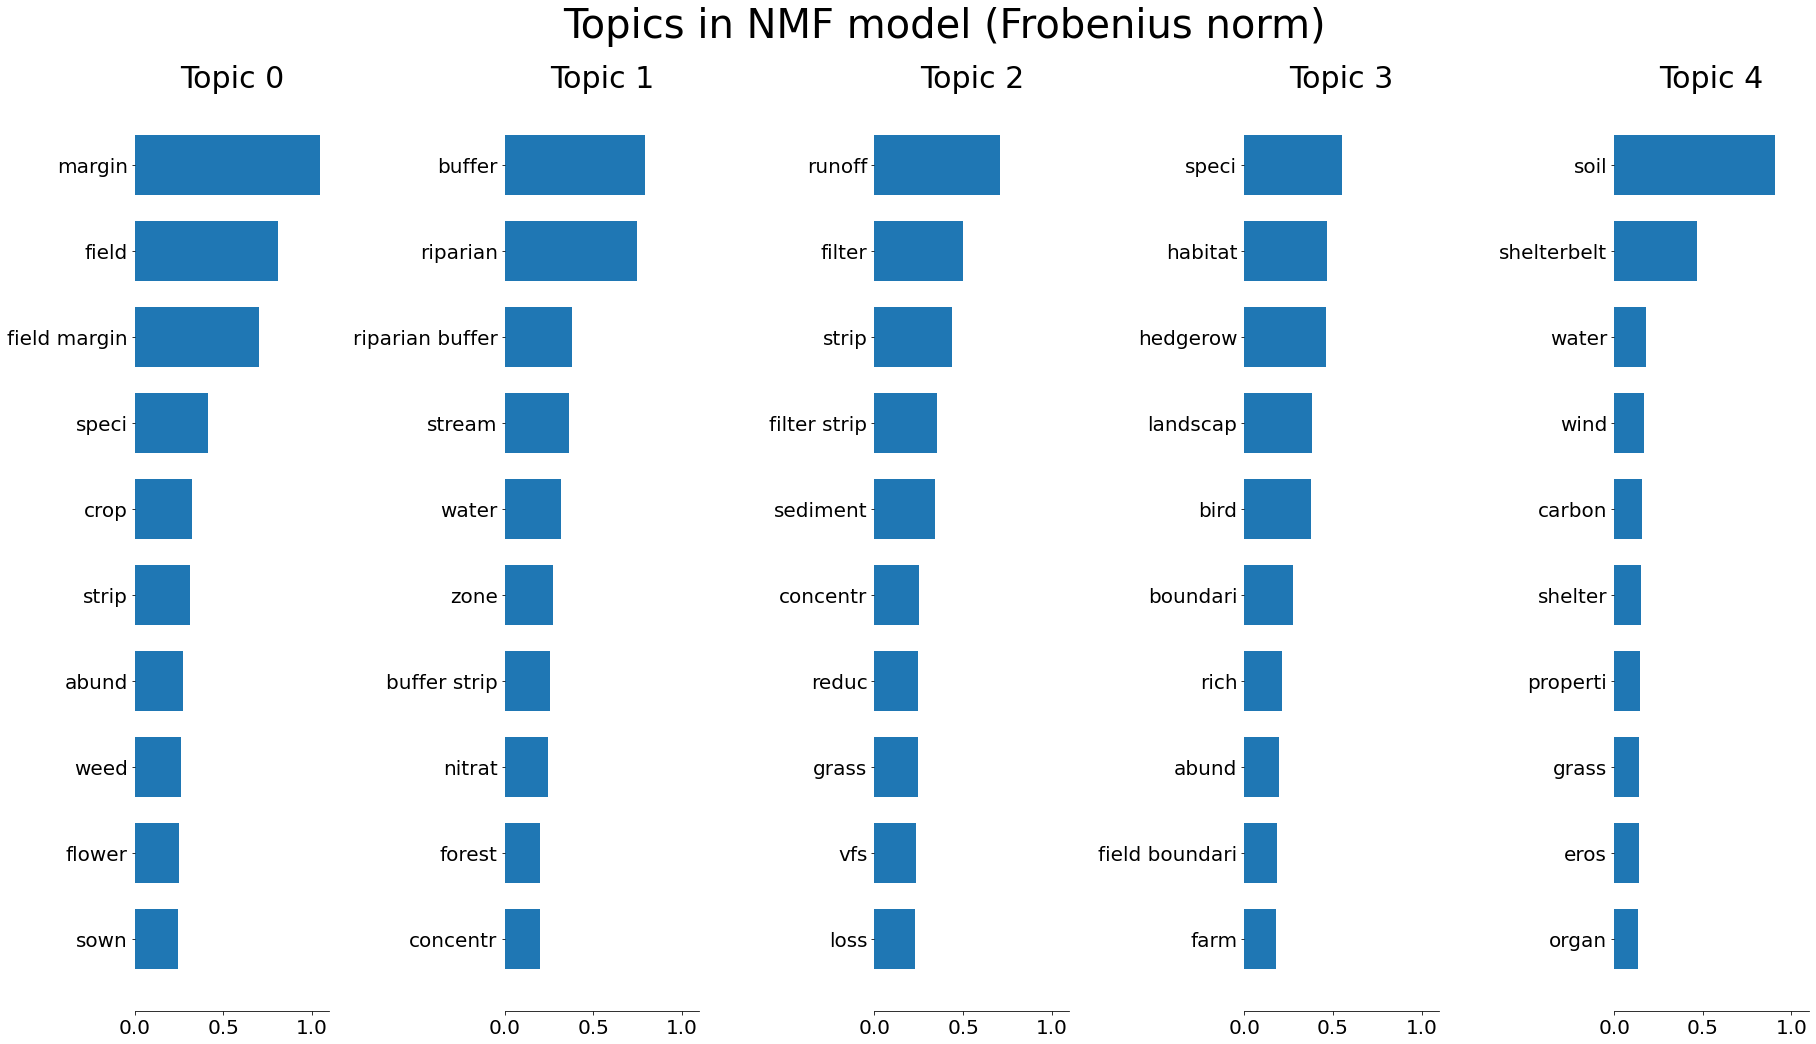

/home/max/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


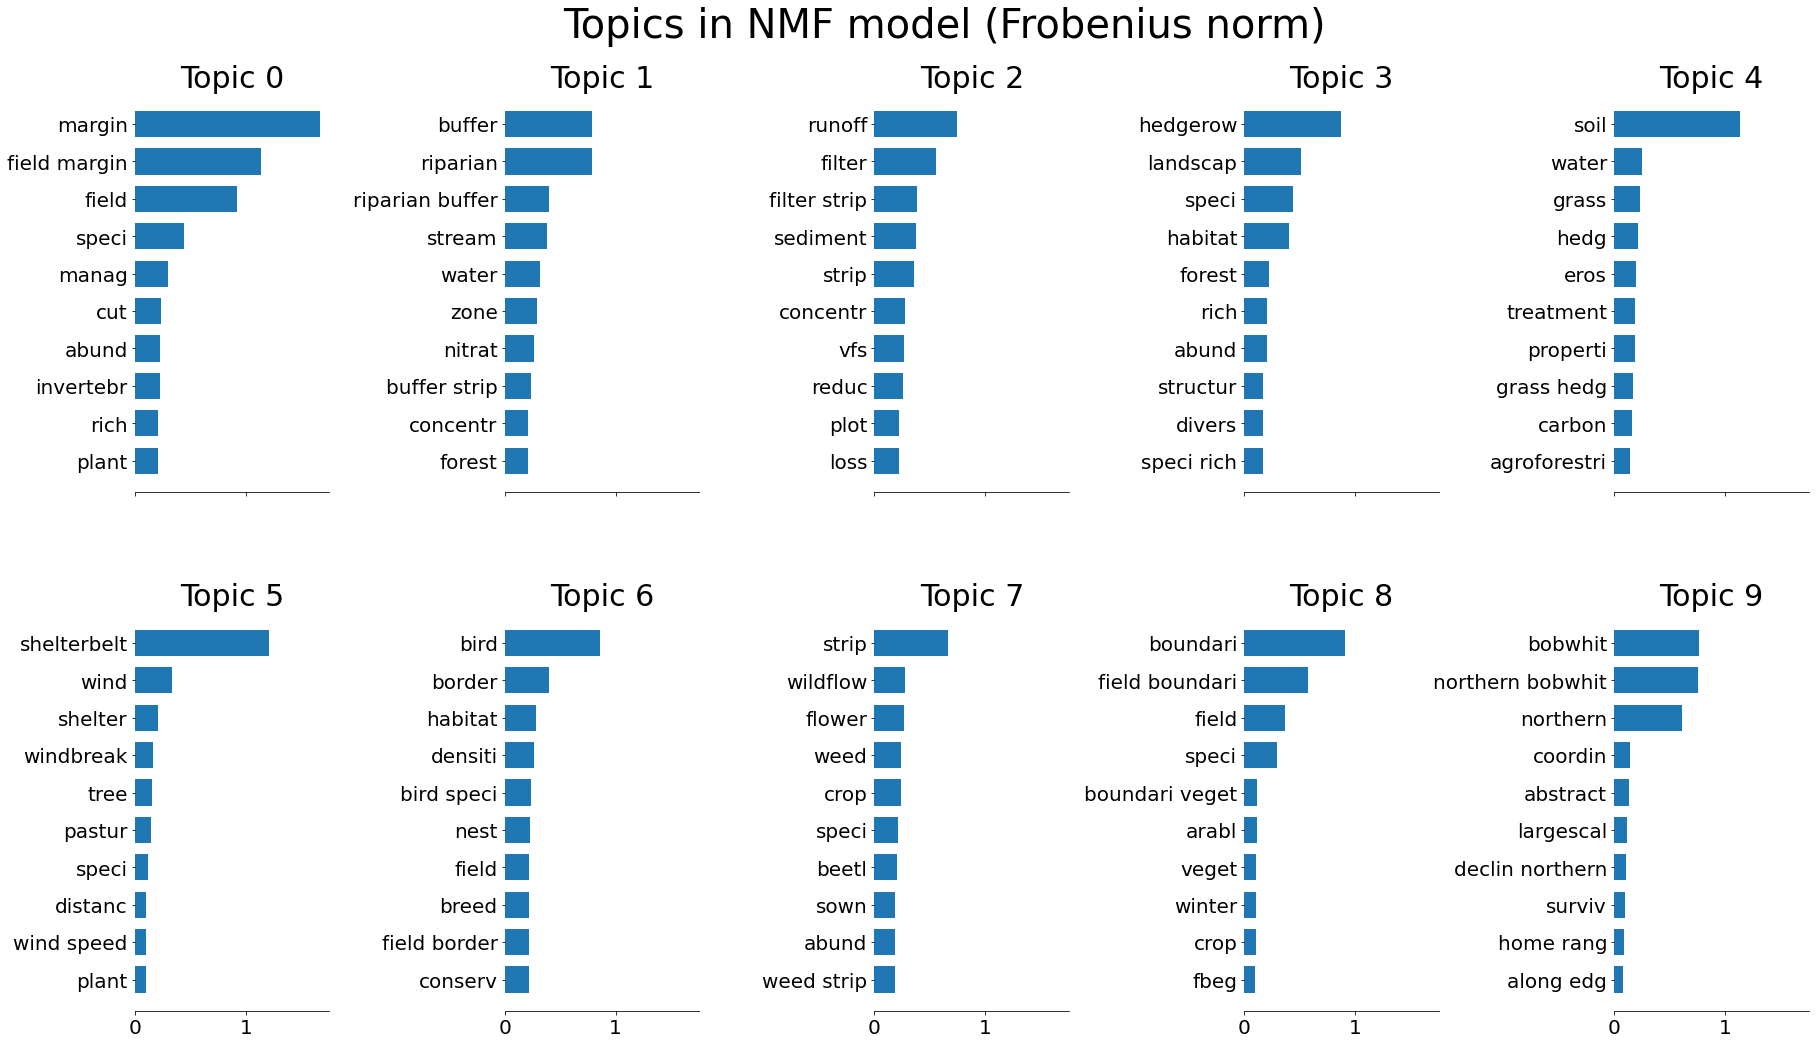

/home/max/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


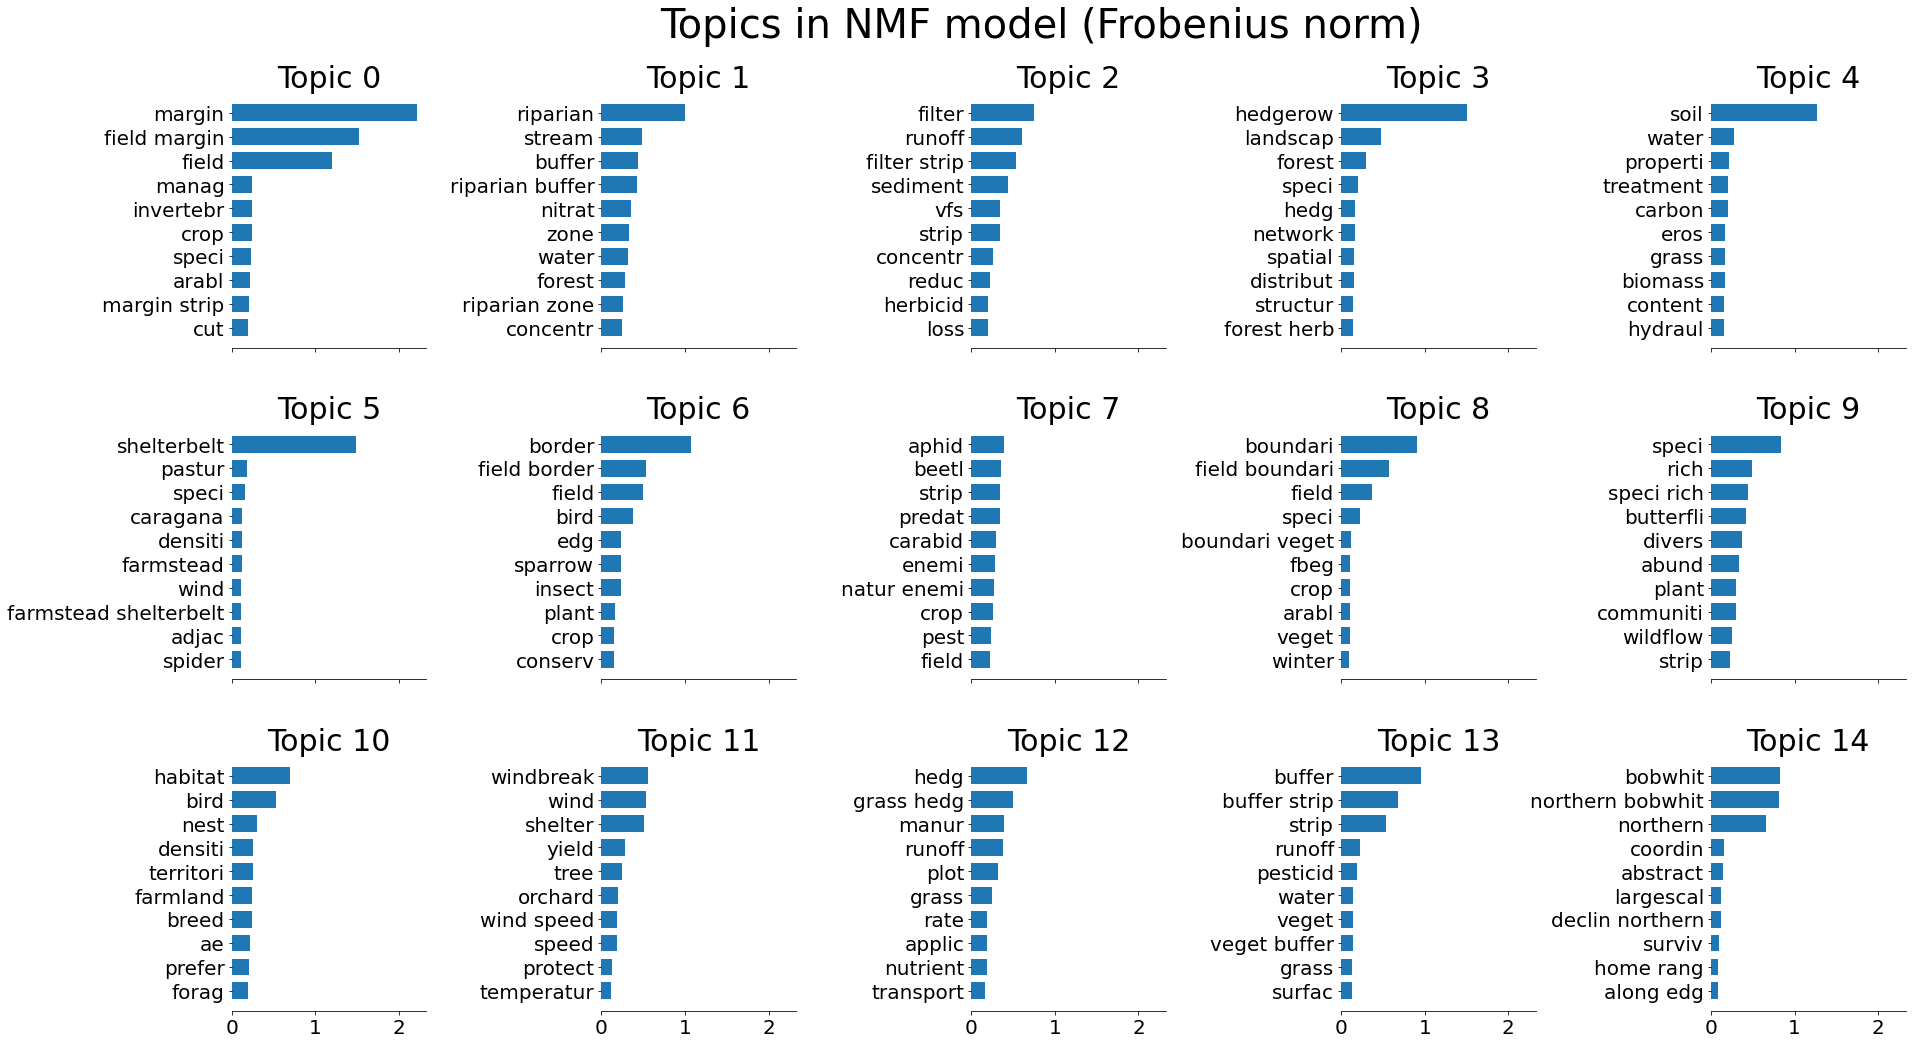

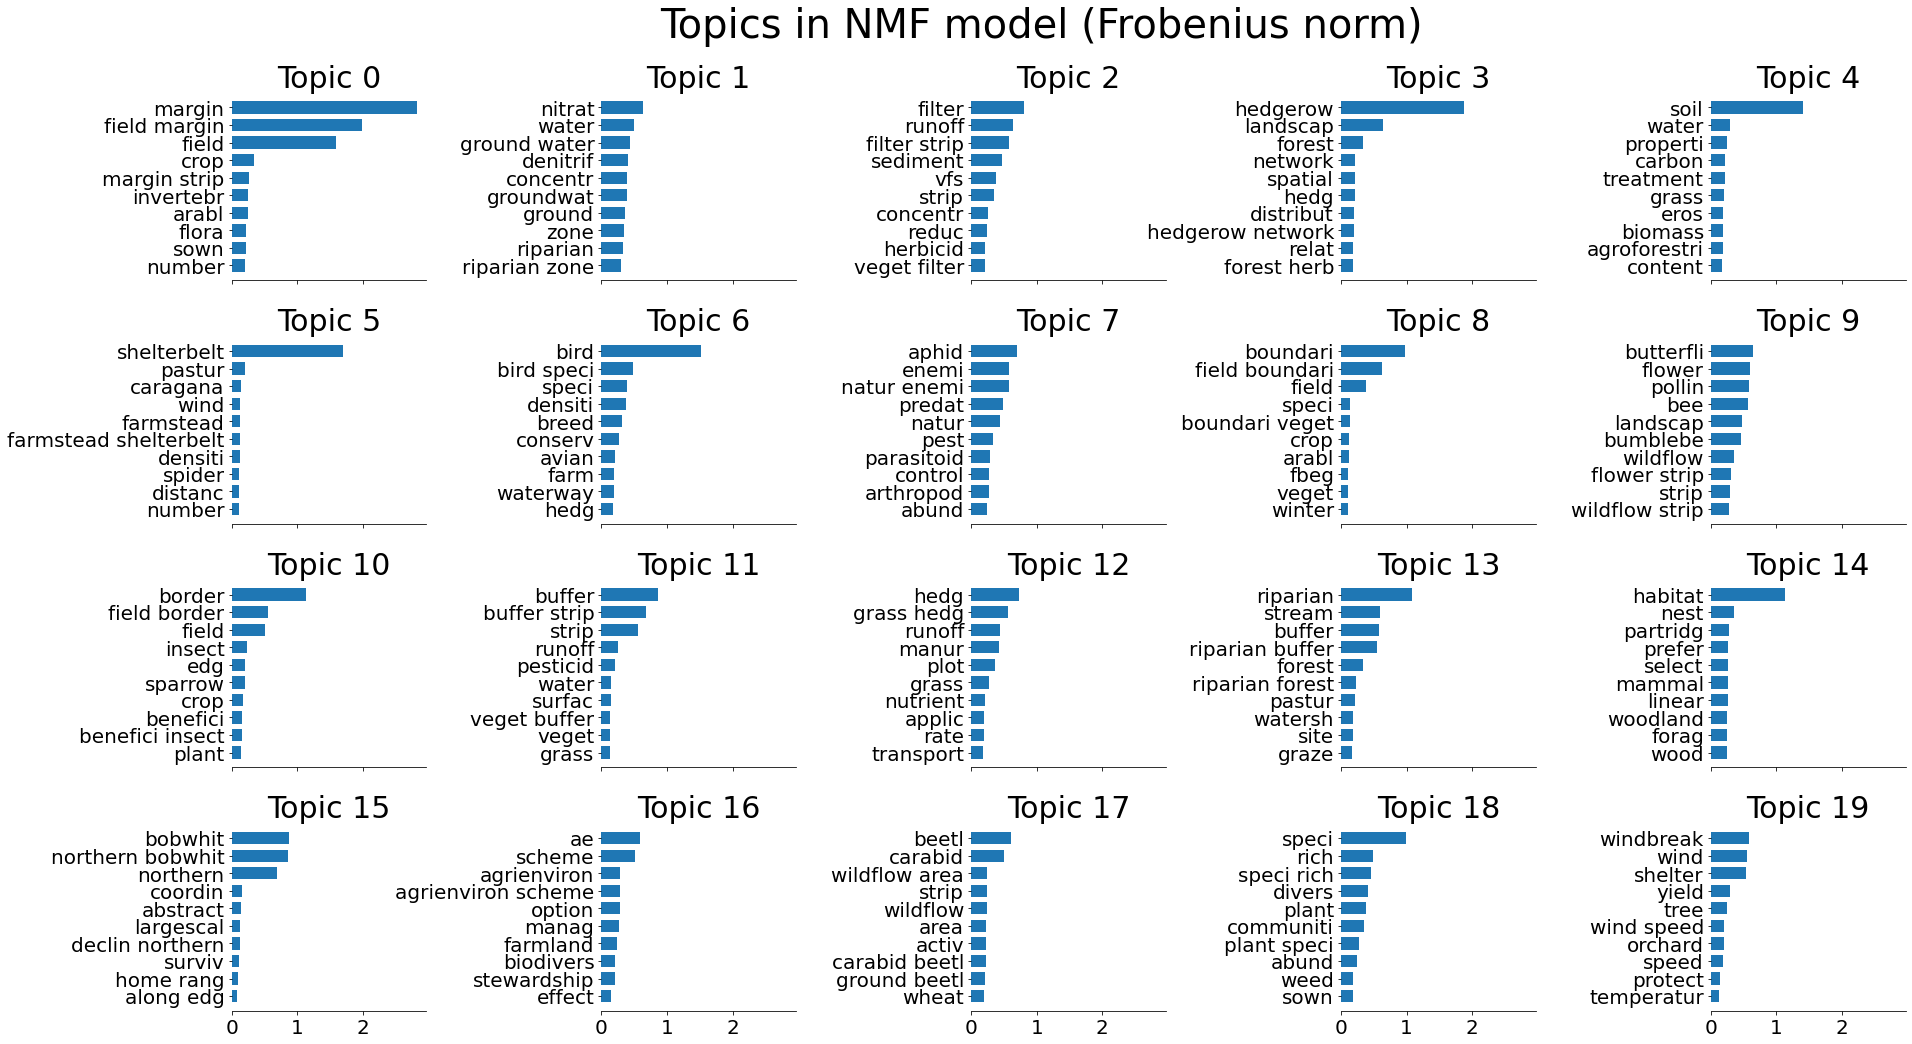

In [6]:
for n_components in [5,10,15,20]:
    n_top_words = 10

    # He we define our model and its parameters
    nmf = NMF(n_components=n_components, random_state=1, l1_ratio=0.5)

    # Now we fit the model on the data and return the document-topic matrix we call W
    W = nmf.fit_transform(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    # We save the results as csvs
    np.savetxt(f"tm-results/nmf_W_{n_components}.csv", W, delimiter=",")
    np.savetxt(f"tm-results/nmf_H_{n_components}.csv", nmf.components_, delimiter=",")
    np.savetxt(f"tm-results/features_{n_components}.csv", tfidf_feature_names, delimiter = ",", fmt='%s')

    # Now we plot the topic words
    t_titles = plot_top_words(
        nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)", n_components
    )

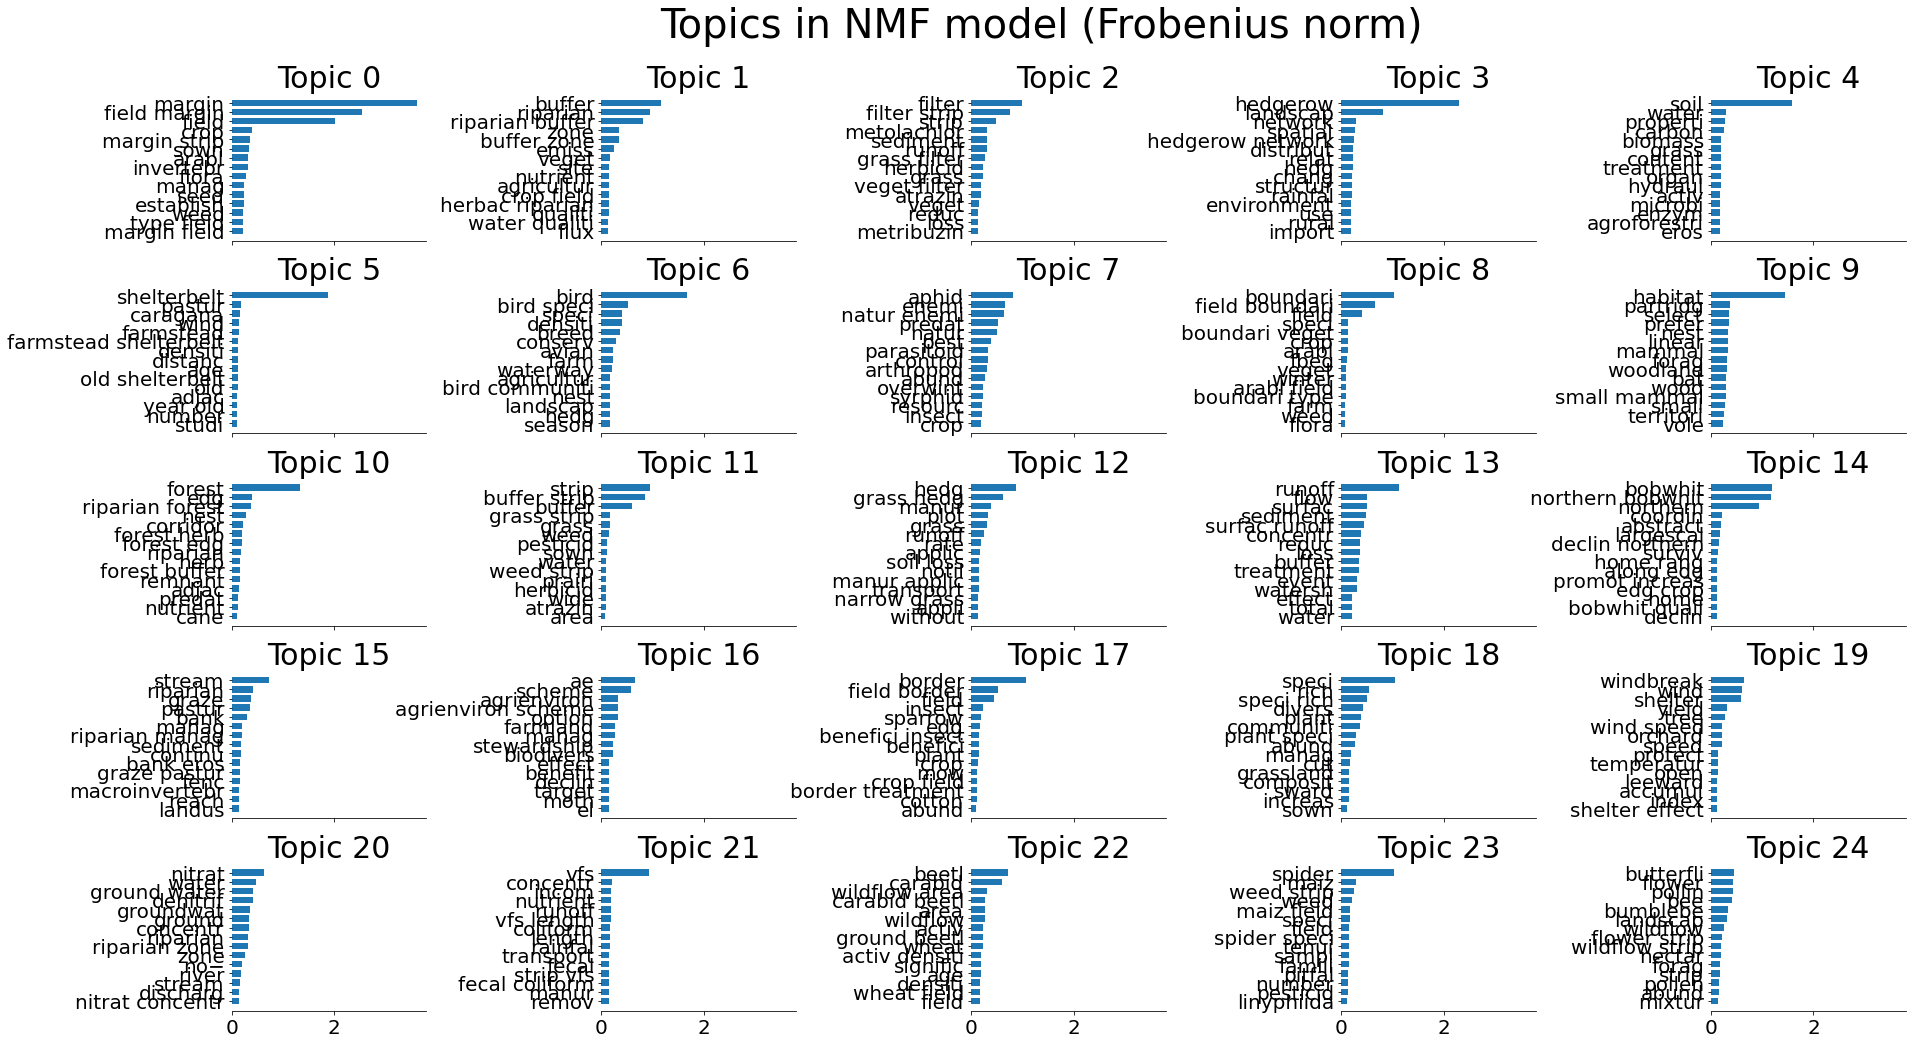

In [7]:
n_components = 25
n_top_words = 15

# He we define our model and its parameters
nmf = NMF(n_components=n_components, random_state=1, l1_ratio=0.5)

# Now we fit the model on the data and return the document-topic matrix we call W
W = nmf.fit_transform(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# We save the results as csvs
np.savetxt(f"tm-results/nmf_W_{n_components}.csv", W, delimiter=",")
np.savetxt(f"tm-results/nmf_H_{n_components}.csv", nmf.components_, delimiter=",")
np.savetxt(f"tm-results/features_{n_components}.csv", tfidf_feature_names, delimiter = ",", fmt='%s')

# Now we plot the topic words
t_titles = plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)", n_components
)

In [8]:
# Here's a quick function to get the documents most associated with a given topic

def get_topic_docs(W, t_index, n_docs):
    dids = np.argsort(W[t_index,:])[::-1][:n_docs]
    for did in dids:
        print()
        print(df['Abstract'][did])
        
# This prints the 1 document most associated with topic 5
get_topic_docs(W, 5, 1)



This study investigates methods to rejuvenate the fl ora of previously degraded fi eld margins on a pastoral farm in County Longford. We also assess the effects of individual treatments on the abundance of various orders of invertebrates recorded within the experimental plots. Field margin treatments were 1.5m-wide unfenced control margins, 1.5m-wide fenced margins or 3.5m-wide fenced margins. Nutrient inputs were excluded from all of the experimental plots. The botanical composition of the plots was examined on four occasions between 2002 and 2004 using permanent, nested quadrats. Emergence traps were used to measure invertebrate abundance within treatment plots and the main sward. Results indicated that 1) exclusion of nutrient inputs had a positive effect on plant species richness within the fi eld margins; 2) plant species richness decreased with increased distance from the hedgerow; 3) herb species richness was greatest in the 1.5m closest to the hedgerow; 4) greater abundance of

## Dimensionality reduction with UMAP

Our doc-topic matrix is still hard to plot because it has `n_components` dimensions. We can use UMAP to reduce this to two dimensions, while maintaining the local and (to some extent) global structure of the multidimensional data

(822, 25)


/home/max/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


(822, 2)


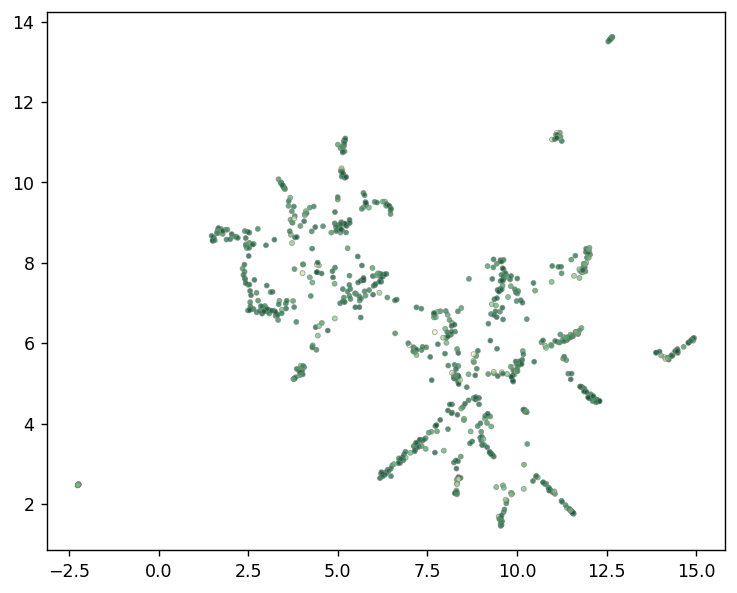

In [9]:
import umap
print(W.shape)
reducer = umap.UMAP()
embedding = reducer.fit_transform(W)
print(embedding.shape)
fig, ax = plt.subplots(figsize=(7,5.7),dpi=125)

ax.scatter(
    embedding[:,0], embedding[:,1], 
    c=df['Publication Year'], cmap='YlGn', 
    alpha=0.7, s=8,
    lw=0.5, ec="grey"
)

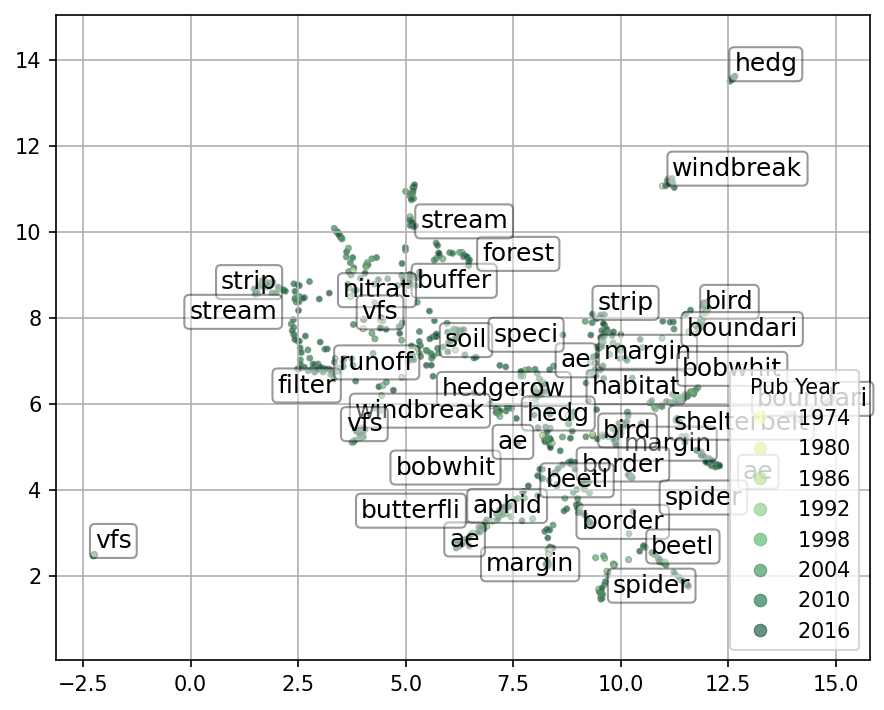

In [10]:
# Now we want to plot this, add topic labels, and use some other aspect of the data to decide the colour of the points

# We import a couple more libraries
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import mpld3
from adjustText import adjust_text

# Initiate a figure object
fig, ax = plt.subplots(figsize=(7,5.7),dpi=150)

# Make a scatter plot with the dimensions of the embedding as X and Y arguments, and the publication year as the colour
scatter = ax.scatter(
    embedding[:,0], embedding[:,1], 
    c=df['Publication Year'], cmap='YlGn', 
    alpha=0.7, s=8,
    lw=0.5, ec="grey"
)

# This function takes a set of points associated with a given topic label, and adds that label in the center of each cluster of points that are found
def cluster_label_points(
    title, points, ax, eps,
    min_cluster, clabel_size,
    ):
    
    # cluster the points and get the cluster numbers of the points
    db = DBSCAN(eps=eps,min_samples=min_cluster).fit(points)
    labels = db.labels_
    texts = []
    
    # For each cluster number
    for l in set(labels):
        # ignore the -1 cluster which is the remainder which cannot be clustered
        if l==-1:
            continue
        
        # get the indices of the points which have this cluster label
        ind = np.argwhere(labels==l).ravel()
        # The label points are those points with those indices
        lpoints = points[ind]
        # As long as the cluster is bigger than the min_cluster parameter, add a label
        if len(ind) > min_cluster:
            # Get the smallest shape that can be drawn around the point
            hull = ConvexHull(lpoints)
            # Get the center of that shape
            cx = np.mean(hull.points[hull.vertices,0])
            cy = np.mean(hull.points[hull.vertices,1])
            c = [cx,cy]
            # Get a short form of the title (just the first term)
            title = title.split(",")[0].replace("{","")
            # Add the label to the plot
            text = ax.annotate(
                title, c, fontsize=clabel_size,
                ha="center",va="center",
                bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'}

            )
            texts.append(text)
    return texts
            
# Set a couple of parameters for the plotting
min_cluster = 5
# eps is a parameter for dbscan: the maximum distance between two samples for them to be considered part of the same neighbourhood
eps = 1
# The font size for the cluster label
clabel_size = 12
# The quantile of doctopic scores for documents to be considered part of a topic
t_thresh = 0.8

# start an empty list of labels, so we can run adjust_text to prevent them overlapping
texts = []

# for each topic
for t_index, title in enumerate(t_titles):
    # Get the nonzero topic scores
    scores = W[:,t_index][W[:,t_index].nonzero()]
    # then get the threshold from those scores given the quantile parameter set above 
    thresh = np.quantile(scores, t_thresh)
    # Get the indices of the documents above that threshold
    highlight_docs = np.argwhere(W[:,t_index]>thresh).ravel()
    # Get the points with those indices
    points = embedding[highlight_docs]
    # label the topic using the function defined above
    texts += cluster_label_points(
        title,
        points,
        ax,
        eps,
        min_cluster,
        clabel_size
    )
    
# Adjust the texts to prevent overlap
adjust_text(texts,ax=ax, arrowprops=dict(arrowstyle="->", color='None', lw=0.5))

    
# add gridlines  
ax.grid(linestyle='-')
# set x and y to be equal sizes
ax.axis('equal')

# Make a quick interactive version and save that to html
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(df['Title']))
mpld3.plugins.connect(fig, tooltip)
with open(f'tm-results/plots/nmf_{n_components}.html','w') as f:
    mpld3.save_html(fig,f)
    
# produce a legend with a cross section of colours from the scatter
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend2 = ax.legend(
    handles, labels, 
    loc="lower right", 
    #bbox_to_anchor=(1.2,0.8),
    title="Pub Year"
)

plt.savefig(f'tm-results/plots/nmf_{n_components}.pdf', bbox_inches="tight")
plt.savefig(f'tm-results/plots/nmf_{n_components}.png', dpi=150, bbox_inches="tight")


## We can also try some other methods for topic modelling, see below

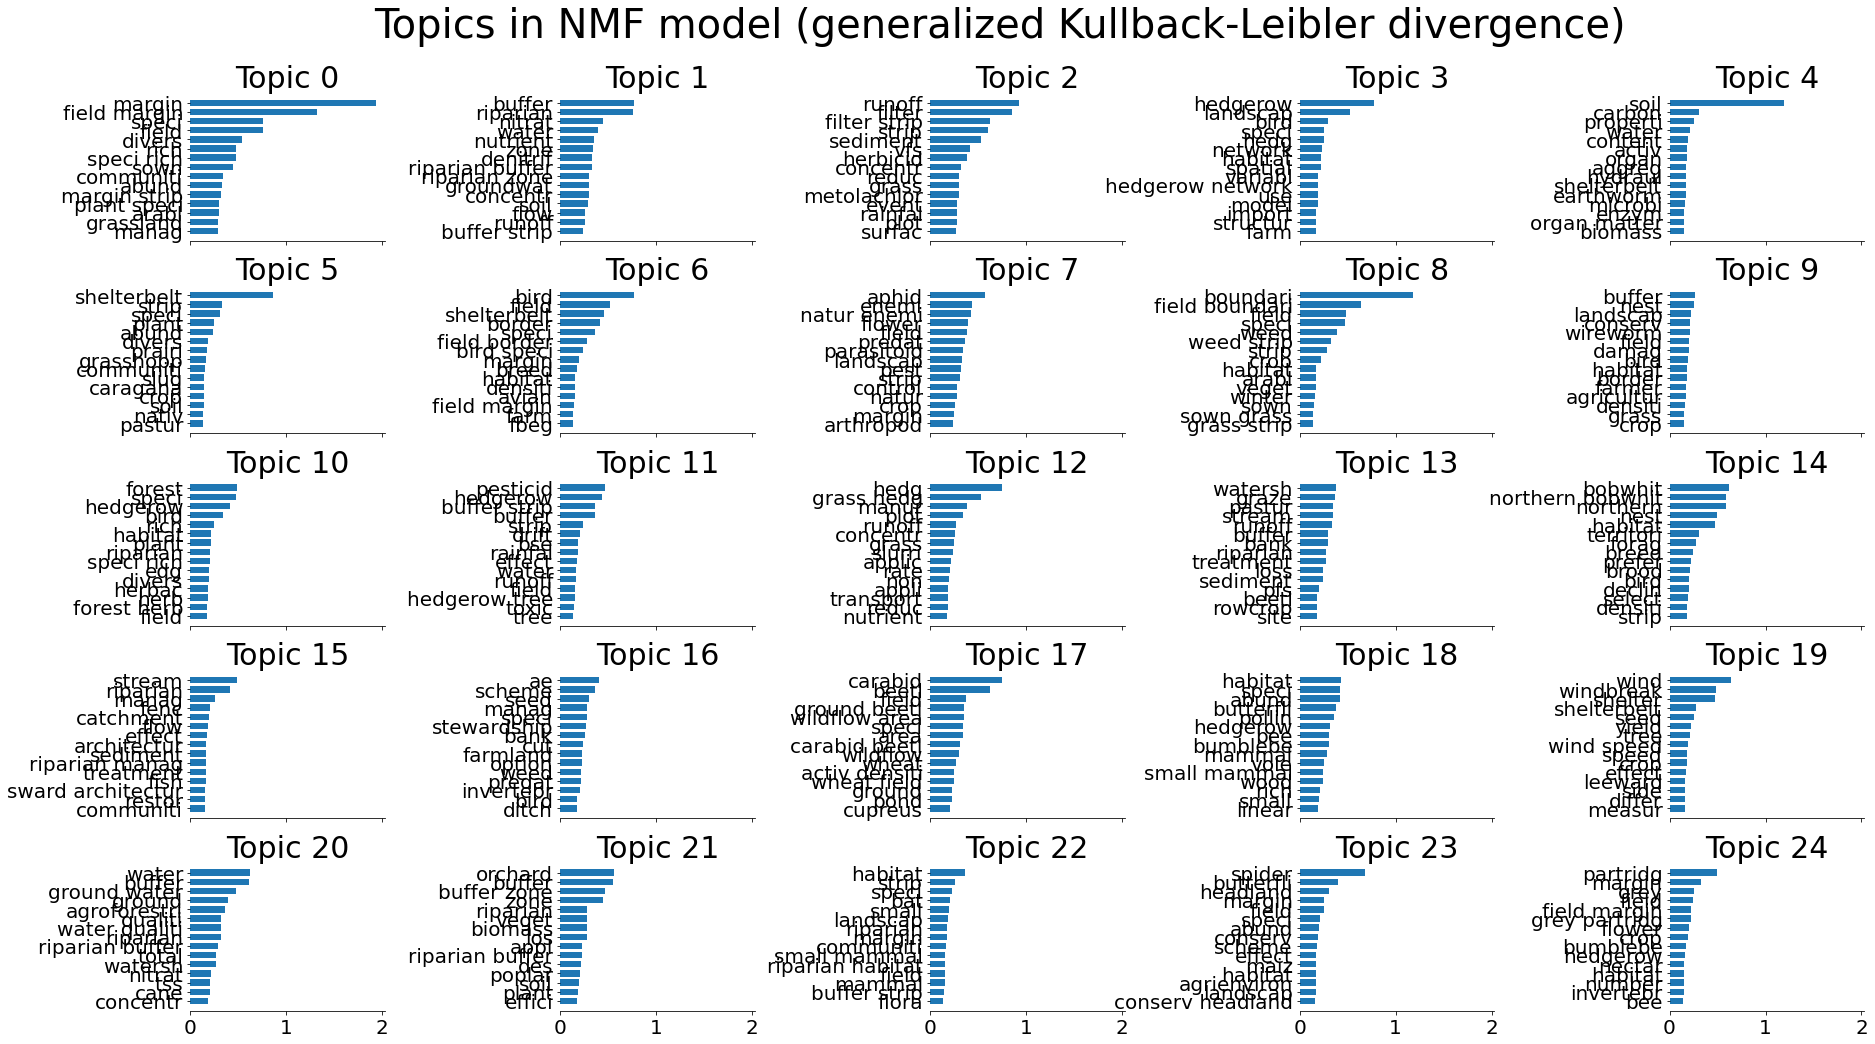

['margin, field margin, speci',
 'buffer, riparian, nitrat',
 'runoff, filter, filter strip',
 'hedgerow, landscap, bird',
 'soil, carbon, properti',
 'shelterbelt, strip, speci',
 'bird, field, shelterbelt',
 'aphid, enemi, natur enemi',
 'boundari, field boundari, field',
 'buffer, nest, landscap',
 'forest, speci, hedgerow',
 'pesticid, hedgerow, buffer strip',
 'hedg, grass hedg, manur',
 'watersh, graze, pastur',
 'bobwhit, northern bobwhit, northern',
 'stream, riparian, manag',
 'ae, scheme, seed',
 'carabid, beetl, field',
 'habitat, speci, abund',
 'wind, windbreak, shelter',
 'water, buffer, ground water',
 'orchard, buffer, buffer zone',
 'habitat, strip, speci',
 'spider, butterfli, headland',
 'partridg, margin, grey']

In [11]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
    n_components
)

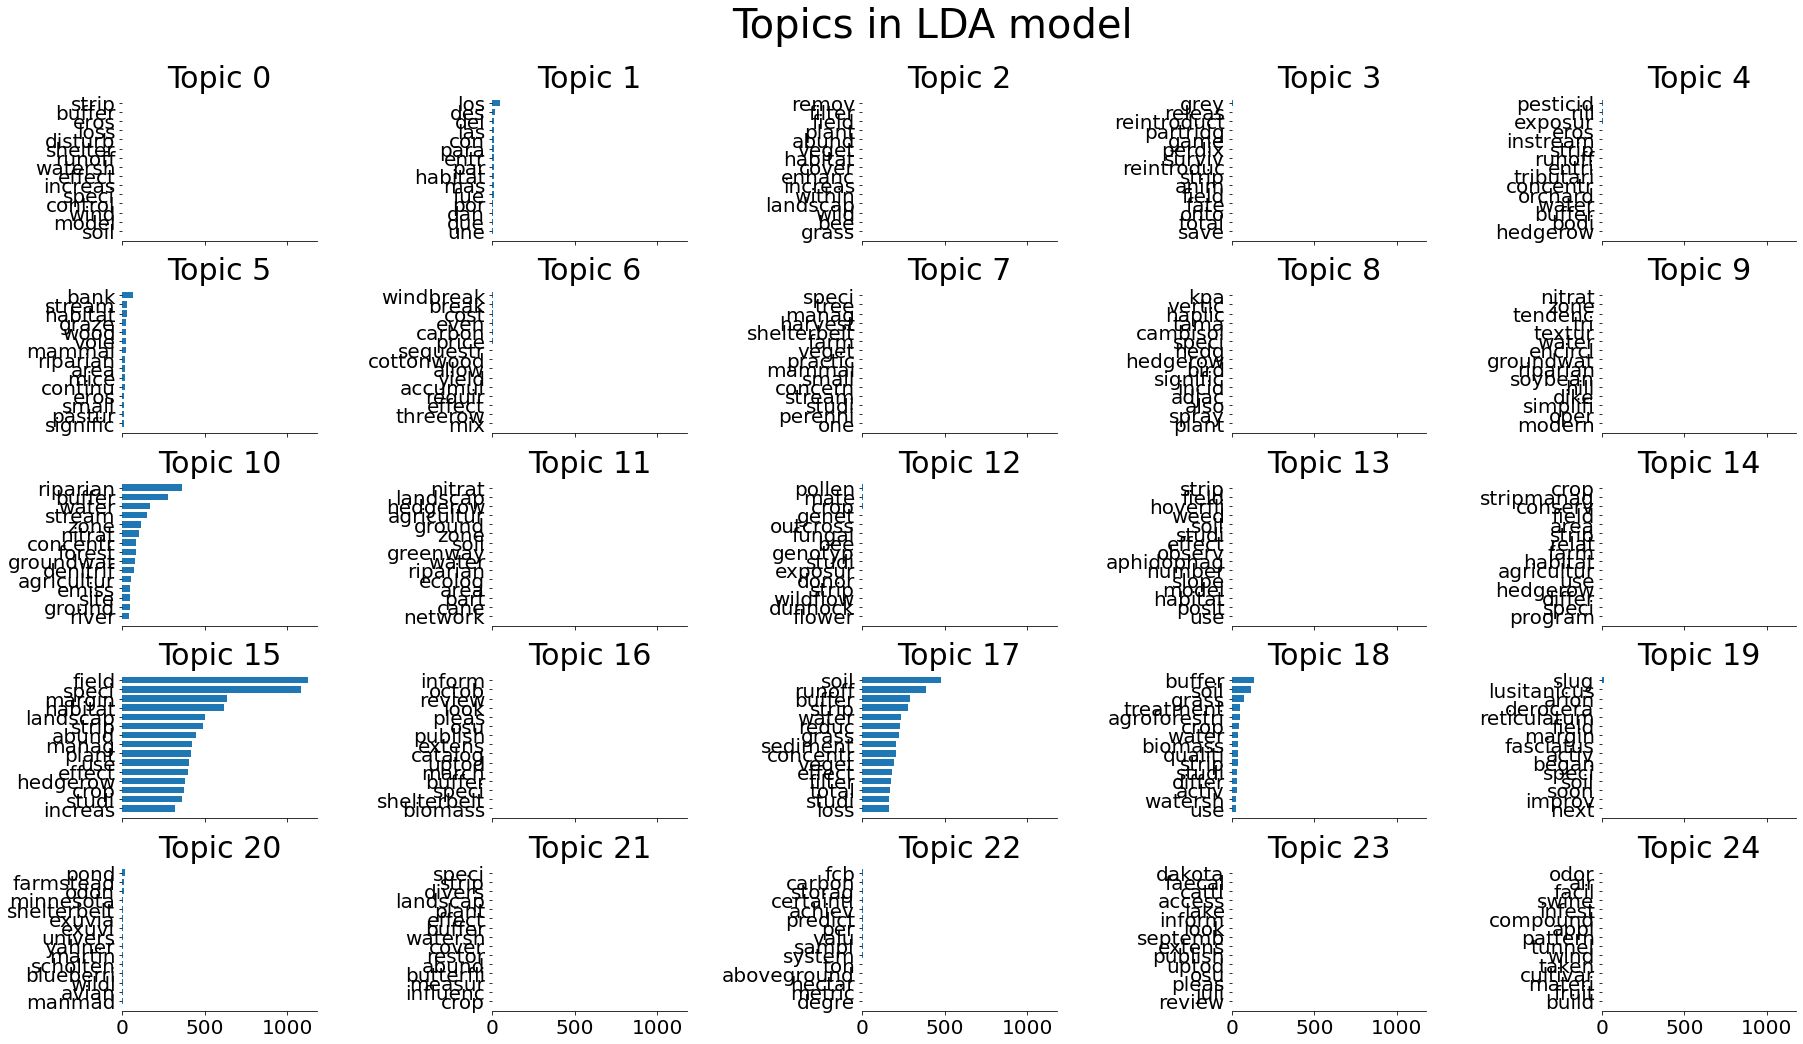

['strip, buffer, eros',
 'los, des, del',
 'remov, filter, field',
 'grey, releas, reintroduct',
 'pesticid, rill, exposur',
 'bank, stream, habitat',
 'windbreak, break, cost',
 'speci, tree, manag',
 'kpa, vertic, haplic',
 'nitrat, zone, tendenc',
 'riparian, buffer, water',
 'nitrat, landscap, hedgerow',
 'pollen, mate, crop',
 'strip, field, hoverfli',
 'crop, stripmanag, conserv',
 'field, speci, margin',
 'inform, octob, review',
 'soil, runoff, buffer',
 'buffer, soil, grass',
 'slug, lusitanicus, arion',
 'pond, farmstead, odon',
 'speci, strip, divers',
 'fcb, carbon, storag',
 'dakota, faecal, cattl',
 'odor, air, facil']

In [12]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model", n_components)